In [2]:
import pandas as pd

In [75]:
baseline = pd.read_json("../results/evaluation_results_baseline_adjusted.json")
zero_shot_raw = pd.read_json("../results/evaluation_results_raw.json").iloc[1:].reset_index(drop=True)
zero_shot_ft = pd.read_json("../results/evaluation_results_ft.json").iloc[1:].reset_index(drop=True)
few_shot_raw = pd.read_json("../results/evaluation_results_raw_3shot.json").iloc[1:].reset_index(drop=True)
few_shot_ft = pd.read_json("../results/evaluation_results_ft_fs_2.json").iloc[1:].reset_index(drop=True)
few_shot_ft_without_rag = pd.read_json("../results/evaluation_results_ft_fixed_examples.json").iloc[1:].reset_index(drop=True)


In [76]:
def get_mean_metrices(df):
    return df[['codebleu', 'bleu', 'rouge']].mean(axis=1)
    # return df['codebleu']

evalutation_results = {
    'baseline': get_mean_metrices(baseline),
    'zero_shot_raw': get_mean_metrices(zero_shot_raw),
    'zero_shot_ft': get_mean_metrices(zero_shot_ft),
    'few_shot_raw': get_mean_metrices(few_shot_raw),
    'few_shot_ft': get_mean_metrices(few_shot_ft),
    'few_shot_ft_without_rag': get_mean_metrices(few_shot_ft_without_rag)
}

evalutation_results = pd.DataFrame(evalutation_results)

In [77]:
evalutation_results

,baseline,zero_shot_raw,zero_shot_ft,few_shot_raw,few_shot_ft,few_shot_ft_without_rag
0,0.905596,0.480666,0.668559,0.683332,0.820090,0.073073
1,0.682779,0.649946,0.905168,0.496026,1.000000,1.000000
2,0.869093,0.551976,0.691203,0.632348,0.083333,0.083333
3,0.939569,0.764638,0.414934,0.688652,0.764230,0.083030
4,0.810837,0.782422,0.777875,0.678346,0.083333,0.125073
...,...,...,...,...,...,...
86,0.787438,1.000000,0.884860,0.772692,0.552505,0.437565
87,0.905737,0.793222,0.947047,0.657869,0.083333,0.083333
88,0.865882,0.703162,0.827640,0.625719,0.083333,0.093862
89,0.900683,0.850846,0.731123,0.740220,0.648797,0.120952


In [78]:
bins = [float('-inf'), 0.6, 0.85, float('inf')]
catagories = {}
for col in evalutation_results.columns:
    catagories[col] = pd.cut(evalutation_results[col], bins, labels=["< 0.6", "0.6 - 0.85", "> 0.85"]).value_counts().sort_index()

# 指标

各种指标（CodeBLEU, BLEU, rouge）反应的效果大体上是一致的，凭感觉进行分段
1. < 0.6 几乎不可用，与实际解决方案相去甚远；
2. 0.6 - 0.85 比较接近，开发者可以参考其输出解决冲突；
3. \> 0.85 与参考输出非常接近，排除个别符号的差异可以直接使用。 

In [79]:
catagories = pd.DataFrame(catagories)

<Axes: >

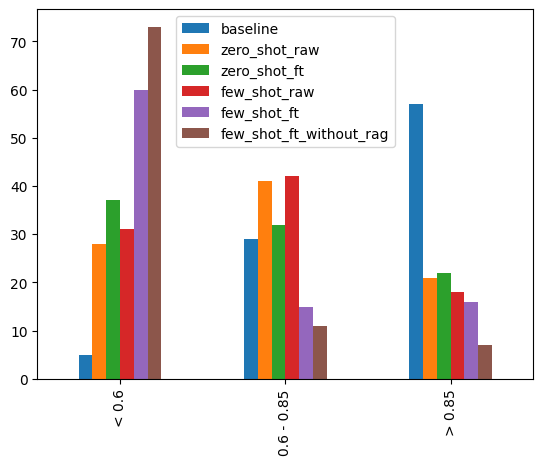

In [80]:
catagories.plot(kind="bar")

# 一些结论

就目前的Baseline以及Llama3的输出结果来看，有一些初步结论：
1. Llama3 无论是通过微调或 *few shot prompting* 后效果均不如 *Baseline*。
2. 微调后的 Llama3 > 0.85 的比重优于没有微调的，但是 < 0.6 的比重却大幅增加。
3. 对比固定示例的 *few shot prompting*，通过 *RAG* 寻找相近的示例解决方案的效果更好，但却不如 *zero shot prompting*。（疑问？是否prompt中举例的方式不对）


也存在Baseline不如llama的例子
> baseline
```json
    {
        "ref": " */\npackage org.sqlite;\n\nimport java.util.Iterator;\nimport java.util.LinkedList;",
        "pred": " */ */\npackage org.sqlite;\n\nimport java.util.Collections;\nimport java.util.LinkedList;\n",
        "codebleu": 0.7281110610329494,
        "bleu": 0.4111336169005197,
        "rouge": 0.9090909090909091,
        "levenshtein": 13
    },
```

> llama finetuning
```json
    {
        "ref": " */\npackage org.sqlite;\n\nimport java.util.Iterator;\nimport java.util.LinkedList;",
        "pred": " */\npackage org.sqlite;\n\nimport java.util.Iterator;\nimport java.util.LinkedList;",
        "codebleu": 1.0,
        "bleu": 1.0,
        "rouge": 1.0,
        "levenshtein": 0
    },
```

目前能想到的提升方案是
1. 用干净的数据增加微调代数。

    Baseline 在数据集上迭代了约 16 epoch（约2小时），Llama 的微调仅进行了 3 epoch（约24小时）。

2. 优化提示词。